# 1. Importing the libraries and datasets

In [ ]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform
from matplotlib import cm
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Import the Postive Data

In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

dataset1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/dataset1.csv') 
dataset2=pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/dataset2.csv') 
print(dataset1.shape)
print(dataset2.shape)

(2042, 1615)
(2042, 1615)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,1304,1305) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Clean from combinations that one molecules has all nan descriptors Nov 26
drop_id = np.concatenate([dataset1.id[dataset1.ABC=='n'].values,dataset2.id[dataset2.ABC=='n'].values])
len(drop_id)
dataset1 = dataset1[~dataset1.id.isin(drop_id)]
dataset2 = dataset2[~dataset2.id.isin(drop_id)]
print(dataset1.shape)
print(dataset2.shape)

(1861, 1615)
(1861, 1615)


In [ ]:
dataset1.head(2)

,id,smiles1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,ADOSOE,CCC1=C(CC)C2=C(c3ccccc3)c4c(CC)c(CC)c5c6cccc(n...,81.49554264,57.05864535,0,0,135.945358,2.728066,5.315293,135.945358,1.332798,5.593096,8.390431,0.082259,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,0.0,12.0,18.0,84.0,3.0,84.0,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,1392.000000,1566.0,2754.000000,...,0.014924,0.009675,0.009366,0.007,0.414349,18.0,13.0,0.384615,0.277778,1329.529335,7.870365,117.0,6.398595,7.349231,8.331586,9.313168,10.308186,11.300660,12.300578,13.297894,14.300028,311.899925,5.459586,0.0,6.874198,4.110874,8.507345,6.734592,10.246474,9.064274,12.047985,165.045327,1365.703304,7.342491,46827.0,237.0,600.0,777.0,32.604167,22.500000
1,ASOPUV,Cc1sc(C)c2SC3=C(Sc4c(C)sc(C)c4S3)Sc12,16.41793436,13.49800851,0,0,26.138494,2.540501,4.981792,26.138494,1.306925,3.980968,4.214951,0.210748,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,0.0,0.0,6.0,12.0,0.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,166.666667,160.0,222.222222,...,0.024427,0.015853,0.000000,0.000,0.517512,9.0,5.0,0.800000,0.444444,255.5462684,5.523562,23.0,4.779123,5.686975,6.621406,7.544861,8.478660,9.406811,10.340031,11.270128,12.203023,119.331019,3.850148,0.0,5.252273,3.044522,6.840547,5.533389,8.515392,7.694848,10.239495,70.970615,371.926326,11.622698,737.0,36.0,118.0,147.0,6.611111,4.111111


## 1.2 Import the Negative Data (Do not need now)

In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot
negatives1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/negatives/negative1.csv') 
negatives2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cocrystal_design/Dataset/negatives/negative2.csv') 
print(negatives1.shape)
print(negatives2.shape)

(11, 1615)
(11, 1615)


In [ ]:
# Set the columns of negative 1 and 2
numerical_cols = dataset1.columns[:]
negatives1.columns = numerical_cols
negatives2.columns = numerical_cols
negatives1.head(2)

,id,smiles1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,c60:picene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.05058,9,9,0.0,0.0,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340,240,540,810,6.666667,10.0
1,c60:fluoroanthene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.0,25.433737,0,0,93.161604,3.0,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.61895,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.05058,9,9,0.0,0.0,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.17694,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.0,12.0,8340,240,540,810,6.666667,10.0


In [ ]:
negatives1

,id,smiles1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,c60:picene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.00000,12.000000,8340,240,540,810,6.666667,10.000000
1,c60:fluoroanthene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.00000,12.000000,8340,240,540,810,6.666667,10.000000
2,"c60:1,9dicyanoanthracene",C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.00000,12.000000,8340,240,540,810,6.666667,10.000000
3,"c60:9,10bis(phenylethyl)anthracene",C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.00000,12.000000,8340,240,540,810,6.666667,10.000000
4,c60:benzanthracene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.00000,12.000000,8340,240,540,810,6.666667,10.000000
5,c60:coronene,C12=C3C4=C5C6=C7C3=C3C8=C1C1=C9C%10=C2C4=C2C4=...,60.000000,25.433737,0,0,93.161604,3.000000,5.618034,93.161604,1.552693,5.290538,7.745967,0.129099,3.838932,697.137002,11.618950,8.338741,60,90,60,60,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,960,1440,2880,...,1.330000e-18,2.470000e-18,0,0,0.050580,9,9,0.00,0.000000,231.571577,7.491853,90,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,

## 1.3 Import the Unlabelled Data - ZINC15

In [ ]:
# Unlabelled data

# Generate the unknown dataset (unlabelled), this might take some minutes

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/Dataset/zinc15_dataset.csv')
val = unlabeled['Identifier'].values
length = len(val)

pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['Identifier'].values
values = unlabeled.iloc[:, 2:].values
d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

1613


In [ ]:
mol1_data= list()
for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 2:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 2:].columns.values) 

In [ ]:
mol1_data

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,412.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
1,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,412.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
2,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,412.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
3,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,412.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
4,14.784941,11.216969,0,0,24.538686,2.561059,5.122118,24.538686,1.363260,3.879562,3.947741,0.219319,1.960930,97.590116,5.421673,5.168563,10,11,26,18,0,0,2,8,0,16,0,2,0,0,0,0,0,0,0,272.0,292.0,446.0,494.0,412.0,...,1.388889e-02,0.000000e+00,0.00000,0.000000,0.385804,7,4,0.750,0.428571,207.9187101,5.392317,21,4.672829,5.587249,6.520621,7.454141,8.392763,9.331052,10.271008,11.210671,12.150999,114.591333,3.761200,0.0,5.141664,0.000000,6.755769,0.000000,8.481980,0.000000,10.268235,52.408848,232.052429,8.925093,501,36,106,133,4.888889,3.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22786,17.273268,12.025541,0,0,28.737241,2.675131,5.141863,28.737241,1.436862,4.035371,4.157708,0.207885,2.118111,127.296420,6.364821,5.539666,20,25,30,20,0,0,0,10,0,20,0,0,0,0,0,0,0,0,0,250.0,325.0,525.0,570.0,485.0,...,0.000000e+00,0.000000e+00,0.00000,0.000000,0.259548,6,4,0.500,0.333333,188.5728203,5.643856,25,4.875197,5.831882,6.803505,7.779467,8.759512,9.741027,10.723730,11.706937,12.690506,123.911764,3.931826,0.0,5.351858,2.3978

# 2. Feature selection
I use both Postive and Unlabelled for Fearture Selection

In [ ]:
# The two datasets are concateanted for identifing the highly correlated descriptors and remove them
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]


#Unlabelled doesn’t need to use iloc[:,2:] because we have done this before
df_unlabelled1_w = mol1_data
df_unlabelled2_w = mol2_data

data_postive = pd.concat([df1_w, df2_w])
data_unlabelled = pd.concat([df_unlabelled1_w, df_unlabelled2_w])

# data = pd.concat([data_postive, data_unlabelled])
data = data_postive

data_ = data.drop_duplicates(keep='first')

In [ ]:
# Drop the highly linearly correlated features among the datasets
# Create correlation matrix
corr_matrix1 = data_.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))

# Find index of feature columns with Pearson correlation greater than 0.92
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.7)]


In [ ]:
# Drop the descriptos will low variance, below 0.4
drop = data_.std()[data_.std() < 0.4].index.values
to_drop2= [x for x in drop if x not in to_drop1]
drop_final= to_drop1 + to_drop2
drop_final = drop

# Remove the selected features from the datasets
df1=df1_w.drop(columns=drop_final)
df1=df1.fillna(0)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


df2=df2_w.drop(columns=drop_final)
df2=df2.fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

df_unlabelled1_w=df_unlabelled1_w.drop(columns=drop_final)
df_unlabelled1_w=df_unlabelled1_w.fillna(0)
df_unlabelled1_w = df_unlabelled1_w.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

df_unlabelled2_w=df_unlabelled2_w.drop(columns=drop_final)
df_unlabelled2_w=df_unlabelled2_w.fillna(0)
df_unlabelled2_w = df_unlabelled2_w.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)



In [ ]:
df2

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,...,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,GGI10,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,60.000000,25.433737,0,0,93.161604,93.161604,5.290538,7.745967,3.838932,697.137002,11.618950,8.338741,60.0,90.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.000000,1440.000000,2880.000000,3840.000000,4800.000000,4800.000000,4800.000000,3840.000000,1440.000000,...,5.833333,1.466667,0.582313,3.470000e-16,2.430000e-16,0.000000,0.000000,9.0,9.0,231.571577,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000
1,60.000000,25.433737,0,0,93.161604,93.161604,5.290538,7.745967,3.838932,697.137002,11.618950,8.338741,60.0,90.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.000000,1440.000000,2880.000000,3840.000000,4800.000000,4800.000000,4800.000000,3840.000000,1440.000000,...,5.833333,1.466667,0.582313,3.050000e-16,2.010000e-16,0.000000,0.000000,9.0,9.0,231.571577,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000
2,60.000000,25.433737,0,0,93.161604,93.161604,5.290538,7.745967,3.838932,697.137002,11.618950,8.338741,60.0,90.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.000000,1440.000000,2880.000000,3840.000000,4800.000000,4800.000000,4800.000000,3840.000000,1440.000000,...,5.833333,1.466667,0.582313,3.050000e-16,2.010000e-16,0.000000,0.000000,9.0,9.0,231.571577,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000
3,60.000000,25.433737,0,0,93.161604,93.161604,5.290538,7.745967,3.838932,697.137002,11.618950,8.338741,60.0,90.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.000000,1440.000000,2880.000000,3840.000000,4800.000000,4800.000000,4800.000000,3840.000000,1440.000000,...,5.833333,1.466667,0.582313,3.050000e-16,2.010000e-16,0.000000,0.000000,9.0,9.0,231.571577,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000
4,60.000000,25.433737,0,0,93.161604,93.161604,5.290538,7.745967,3.838932,697.137002,11.618950,8.338741,60.0,90.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,960.000000,1440.000000,2880.000000,3840.000000,4800.000000,4800.000000,4800.000000,3840.000000,1440.000000,...,5.833333,1.466667,0.582313,3.470000e-16,2.430000e-16,0.000000,0.000000,9.0,9.0,231.571577,7.491853,90.0,6.293419,7.390799,8.488999,9.587475,10.686041,11.784638,12.883245,13.981856,15.080468,246.176940,5.198497,0.0,6.803505,4.795791,8.605387,7.427144,10.502901,9.817984,12.454888,125.606097,720.000000,12.000000,8340.0,240.0,540.0,810.0,6.666667,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
print(df_unlabelled1_w.shape)
print(df_unlabelled2_w.shape)

(22791, 979)
(22791, 979)


In [ ]:
# # Calculate the Spearman correlations of the datasets
# df1 = pd.concat([df1, df_unlabelled1_w])# concat the first table with postive and negative 
# df2 = pd.concat([df2, df_unlabelled2_w])# concat the second table with postive and negative 

In [ ]:
df1

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,...,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,GGI10,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,81.495543,57.058645,0,0,135.945358,135.945358,5.593096,8.390431,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,0.0,12.0,18.0,84.0,3.0,84.0,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,1392.000000,1566.000000,2754.000000,3327.000000,4221.000000,4461.000000,4374.000000,4227.000000,4263.000000,...,15.993333,10.130000,7.231293,5.417304,3.483088,3.540185,2.708956,18.0,13.0,1329.529335,7.870365,117.0,6.398595,7.349231,8.331586,9.313168,10.308186,11.300660,12.300578,13.297894,14.300028,311.899925,5.459586,0.0,6.874198,4.110874,8.507345,6.734592,10.246474,9.064274,12.047985,165.045327,1365.703304,7.342491,46827.0,237.0,600.0,777.0,32.604167,22.500000
1,16.417934,13.498009,0,0,26.138494,26.138494,3.980968,4.214951,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,0.0,0.0,6.0,12.0,0.0,14.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,166.666667,160.000000,222.222222,187.555556,148.666667,127.111111,125.333333,74.666667,21.111111,...,1.438889,0.681111,0.375420,0.341978,0.174383,0.000000,0.000000,9.0,5.0,255.546268,5.523562,23.0,4.779123,5.686975,6.621406,7.544861,8.478660,9.406811,10.340031,11.270128,12.203023,119.331019,3.850148,0.0,5.252273,3.044522,6.840547,5.533389,8.515392,7.694848,10.239495,70.970615,371.926326,11.622698,737.0,36.0,118.0,147.0,6.611111,4.111111
2,20.303896,15.081277,0,0,34.684121,34.684121,4.205946,4.543092,2.469119,202.604740,7.792490,6.266768,18.0,20.0,42.0,26.0,0.0,0.0,8.0,16.0,0.0,18.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,345.777778,317.333333,438.222222,493.111111,337.333333,295.333333,271.333333,260.666667,266.666667,...,2.417778,0.805556,0.724898,0.361111,0.311413,0.182500,0.148556,13.0,7.0,317.600150,5.857981,29.0,4.962845,5.849325,6.755769,7.660585,8.571492,9.482122,10.395222,11.308591,12.223161,132.209112,4.077537,0.0,5.424950,0.000000,6.994850,0.000000,8.667508,0.000000,10.392037,61.556882,423.993143,10.095075,1653.0,48.0,142.0,173.0,8.111111,5.888889
3,15.572928,12.071863,0,0,25.544066,25.544066,3.926927,4.030530,2.035752,115.359218,6.071538,5.389905,17.0,19.0,29.0,19.0,0.0,0.0,5.0,10.0,0.0,14.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,168.222222,165.666667,224.222222,197.000000,151.666667,135.555556,122.666667,90.000000,40.000000,...,1.386111,0.451667,0.388526,0.230938,0.064508,0.031250,0.000000,9.0,5.0,234.400785,5.459432,22.0,4.709530,5.602119,6.517671,7.427144,8.345455,9.260748,10.180172,11.098061,12.018133,116.159035,3.806662,0.0,5.176150,2.397895,6.751101,4.844187,8.420021,7.002156,10.138362,67.536535,337.938605,11.653055,649.0,33.0,110.0,135.0,5.138889,3.972222
4,79.725139,42.600168,0,0,133.964519,133.964519,5.544732,8.048479,4.347246,2193.605731,22.850060,9.955065,90.0,105.0,153.0,96.0,0.0,12.0,15.0,57.0,0.0,81.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.000000,1548.000000,2328.000000,2562.000000,2619.000000,2682.000000,2928.000000,3174.000000,3519.000000,...,6.333333,3.708333,2.786939,2.421875,2.109599,1.695000,1.485155,24.0,16.0,1021.878675,7.832890,114.0,6.347389,7.260523,8.185629,9.109746,10.038499,10.966075,11.896438,12.825716,13.757124,300.387139,5.433722,0.0,6.816736,0.000000,8.410721,0.000000,10.100739,0.000000,11.842941,138.604859,1239.492137,8.101256,49806.0,201.0,570.0,711.0,20.833333,20.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
cor = df1.corrwith(df2, axis=0, drop=False, method='spearman').abs()
corr=cor.sort_values(ascending=False)

In [ ]:
corr

GGI5           0.759585
ATS7i          0.742945
ATS8i          0.742001
ATS7se         0.738719
ATS8se         0.738462
                 ...   
ATSC6se        0.001475
AATSC8i        0.001322
VSA_EState5    0.001264
ATSC8m         0.000757
MINdssC        0.000695
Length: 979, dtype: float64

In [ ]:
# Construct a vector w which is used to keep only the descriptors that are correlated higher than 0.30 using Spearman correlation
# In this vector, 1 is on the positions of the descriptors that have correlation coeficcient > 0.1,  and 0 otherwise
w = np.array(cor)
np.nan_to_num(w,0)
w[w<0.4] =0
w[w=='NaN']=0
w[w>=0.4] =1

# Multiply the two datasets with the vector w, such that the descriptors with lower correlation will become zero and removed 
df1 = df1*w
df2 = df2*w

df1_1 = df1.loc[:, (df1 != 0).any(axis=0)]
df2_2 = df2.loc[:, (df2 != 0).any(axis=0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [ ]:
df1_1

,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nHetero,nH,nC,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,ATS0d,ATS1d,ATS2d,ATS3d,ATS4d,ATS5d,ATS6d,ATS7d,ATS8d,ATS0s,ATS1s,ATS2s,ATS3s,ATS4s,...,TopoPSA(NO),TopoPSA,GGI1,GGI2,GGI3,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,GGI10,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW04,SRW06,SRW08,SRW10,TSRW10,MW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,81.495543,57.058645,135.945358,135.945358,5.593096,8.390431,4.449480,1978.454830,19.396616,9.912459,51.0,51.0,186.0,102.0,18.0,84.0,84.0,1392.000000,1566.000000,2754.000000,3327.000000,4221.000000,4461.000000,4374.000000,4227.000000,4263.000000,684.0,909.0,1572.0,2040.0,2445.0,2901.0,3270.0,3420.0,3471.0,791.020833,566.083333,1181.000000,1326.916667,1789.583333,...,62.49,62.49,16.5,12.666667,14.875000,15.993333,10.130000,7.231293,5.417304,3.483088,3.540185,2.708956,18.0,13.0,1329.529335,7.870365,117.0,6.398595,7.349231,8.331586,9.313168,10.308186,11.300660,12.300578,13.297894,14.300028,311.899925,5.459586,6.874198,8.507345,10.246474,12.047985,165.045327,1365.703304,46827.0,237.0,600.0,777.0,32.604167,22.500000
1,16.417934,13.498009,26.138494,26.138494,3.980968,4.214951,2.131785,107.969249,5.398462,5.374994,16.0,18.0,32.0,20.0,6.0,12.0,14.0,166.666667,160.000000,222.222222,187.555556,148.666667,127.111111,125.333333,74.666667,21.111111,130.0,159.0,262.0,244.0,244.0,186.0,176.0,126.0,98.0,58.298354,69.740741,96.420439,93.854595,103.925926,...,0.00,169.44,5.0,3.111111,2.527778,1.438889,0.681111,0.375420,0.341978,0.174383,0.000000,0.000000,9.0,5.0,255.546268,5.523562,23.0,4.779123,5.686975,6.621406,7.544861,8.478660,9.406811,10.340031,11.270128,12.203023,119.331019,3.850148,5.252273,6.840547,8.515392,10.239495,70.970615,371.926326,737.0,36.0,118.0,147.0,6.611111,4.111111
2,20.303896,15.081277,34.684121,34.684121,4.205946,4.543092,2.469119,202.604740,7.792490,6.266768,18.0,20.0,42.0,26.0,8.0,16.0,18.0,345.777778,317.333333,438.222222,493.111111,337.333333,295.333333,271.333333,260.666667,266.666667,158.0,193.0,304.0,328.0,310.0,302.0,256.0,226.0,184.0,126.458162,132.530864,195.556241,214.155693,216.827160,...,36.92,149.88,6.0,3.111111,1.750000,2.417778,0.805556,0.724898,0.361111,0.311413,0.182500,0.148556,13.0,7.0,317.600150,5.857981,29.0,4.962845,5.849325,6.755769,7.660585,8.571492,9.482122,10.395222,11.308591,12.223161,132.209112,4.077537,5.424950,6.994850,8.667508,10.392037,61.556882,423.993143,1653.0,48.0,142.0,173.0,8.111111,5.888889
3,15.572928,12.071863,25.544066,25.544066,3.926927,4.030530,2.035752,115.359218,6.071538,5.389905,17.0,19.0,29.0,19.0,5.0,10.0,14.0,168.222222,165.666667,224.222222,197.000000,151.666667,135.555556,122.666667,90.000000,40.000000,120.0,149.0,235.0,231.0,209.0,163.0,143.0,106.0,82.0,58.322702,70.024691,97.766118,96.965021,90.679012,...,0.00,141.20,4.0,2.444444,1.638889,1.386111,0.451667,0.388526,0.230938,0.064508,0.031250,0.000000,9.0,5.0,234.400785,5.459432,22.0,4.709530,5.602119,6.517671,7.427144,8.345455,9.260748,10.180172,11.098061,12.018133,116.159035,3.806662,5.176150,6.751101,8.420021,10.138362,67.536535,337.938605,649.0,33.0,110.0,135.0,5.138889,3.972222
4,79.725139,42.600168,133.964519,133.964519,5.544732,8.048479,4.347246,2193.605731,22.850060,9.955065,90.0,105.0,153.0,96.0,15.0,57.0,81.0,1296.000000,1548.000000,2328.000000,2562.000000,2619.000000,2682.000000,2928.000000,3174.000000,3519.000000,627.0,816.0,1329.0,1641.0,1728.0,1845.0,1896.0,1989.0,2181.0,440.416667,529.500000,856.166667,1063.666667,1268.666667,...,145.59,145.59,15.0,12.000000,7.312500,6.333333,3.708333,2.786939,2.421875,2.109599,1.695000,1.485155,24.0,16.0,1021.878675,7.832890,114.0,6.347389,7.260523,8.185629,9.109746,10.038499,10.966075,11.896438,12.825716,13.757124,300.387139,5.433722,6.816736,8.410721,10.100739,11.842941,138.604859,1239.492137,49806.0,201.0,570.0,711.0,20.833333,20.083333
...,...,...,...,...,.

In [ ]:
# Calculate the Pearson correlations of the datasets 
cort= df1_1.corrwith(df2_2, axis=0, drop=False, method='pearson').abs()
corrt=cort.sort_values(ascending=False)

In [ ]:
# Keep only descriptors with Pearson correlations > 0.4
w = np.array(cort)
np.nan_to_num(w,0)
w[w<0.4]=0
w[w>=0.4]=1
df1_1 = df1_1*w
df2_2 = df2_2*w
df1_1 = df1_1.loc[:, (df1_1 != 0).any(axis=0)]
df2_2 = df2_2.loc[:, (df2_2 != 0).any(axis=0)]

In [ ]:
# Print out the p-value
#\hline
# & ABCGG & Graovac-Ghorbani atom-bond connectivity\\
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr

for i in df1_1.columns.values:
  print("\hline")
  print("%s"% i + " " + 'Correlation:%2f' %  pearsonr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" %  pearsonr(df1_1[i].values, df2_2[i].values)[1])

#Save to a list the important features and then from both the positives and negatives keep only these features

\hline
ABC Correlation:-0.417920  p-value:0.000000
\hline
ABCGG Correlation:-0.524589  p-value:0.000000
\hline
SpAbs_A Correlation:-0.422294  p-value:0.000000
\hline
SpAD_A Correlation:-0.422294  p-value:0.000000
\hline
LogEE_A Correlation:-0.744097  p-value:0.000000
\hline
VE1_A Correlation:-0.540067  p-value:0.000000
\hline
VE3_A Correlation:-0.741695  p-value:0.000000
\hline
VR3_A Correlation:-0.738404  p-value:0.000000
\hline
nAtom Correlation:-0.413205  p-value:0.000000
\hline
nHeavyAtom Correlation:-0.450761  p-value:0.000000
\hline
ATS0dv Correlation:-0.420977  p-value:0.000000
\hline
ATS1s Correlation:-0.469583  p-value:0.000000
\hline
ATS2s Correlation:-0.456686  p-value:0.000000
\hline
ATS3s Correlation:-0.423619  p-value:0.000000
\hline
ATS4s Correlation:-0.434271  p-value:0.000000
\hline
ATS5s Correlation:-0.439521  p-value:0.000000
\hline
ATS1Z Correlation:-0.429553  p-value:0.000000
\hline
ATS1m Correlation:-0.414616  p-value:0.000000
\hline
ATS0v Correlation:-0.433682  p

In [ ]:
selected_features = df1_1.columns
selected_features

Index(['ABC', 'ABCGG', 'SpAbs_A', 'SpAD_A', 'LogEE_A', 'VE1_A', 'VE3_A',
       'VR3_A', 'nAtom', 'nHeavyAtom',
       ...
       'TMWC10', 'SRW02', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10', 'MW',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=206)

In [ ]:
selected_features.shape


(206,)

# 3. Normalization and Concat_bidirectional of Dataset

## 3.1  Normalization with positives and Unlabelled 

In [ ]:
#get the postive data and fillna to 0
df1=dataset1.iloc[:,2:]
df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(0)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
df2 = df2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

#select feature
df1 = df1[selected_features]
df2 = df2[selected_features]

print(df1.shape)
print(df2.shape)

(1861, 206)
(1861, 206)


In [ ]:
# Replace errors with 0 on the unlabelled dataset
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

final_11 = final_1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
final_22 = final_2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

#select feature
final_11 = final_11[selected_features]
final_22 = final_22[selected_features]

print(final_11.shape)
print(final_22.shape)


(22791, 206)
(22791, 206)


In [ ]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['id'], dataset11, dataset22], axis=1), pd.concat([dataset1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])

def unlabelled_concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([final_11['comb'], dataset11, dataset22], axis=1), pd.concat([final_11['comb'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])



In [ ]:
# Standarize the positive data

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
df_concat_unlabelled = pd.concat([final_11, final_22])

df_concat = pd.concat([df_concat, df_concat_unlabelled])

df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

#2/1 edit
df2_scaled_ = df2_scaled.add_suffix('_')


# Standarize the unlabeled data

final_11 = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_11.values, columns=final_11.columns)],axis=1) 
#skip the comb
unlabeled_1_scaled= final_11.iloc[:,1:]
final_1_scaled = pd.DataFrame(X_scaler.transform(unlabeled_1_scaled),columns=numerical_cols, index=final_11.index)

final_22 = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_22.values, columns=final_22.columns)],axis=1) 
#skip the comb
unlabeled_2_scaled= final_22.iloc[:,1:]
final_2_scaled = pd.DataFrame(X_scaler.transform(unlabeled_2_scaled),columns=numerical_cols, index=final_11.index)

#2/1 edit
final_2_scaled_ = final_2_scaled.add_suffix('_')


# Final bidirectional concatenated dataset, after feature selection and scaling 
positive_data = concat_bidirectional(df1_scaled,df2_scaled)
positive_data_ = concat_bidirectional(df1_scaled,df2_scaled_)
unlabelled_data = unlabelled_concat_bidirectional(final_1_scaled,final_2_scaled)
unlabelled_data_ = unlabelled_concat_bidirectional(final_1_scaled,final_2_scaled_)


In [ ]:
# Assing the label = 1 for all the positive data
positive_data['label']=1
positive_data_['label']=1

In [ ]:
# Assing the label = 0 for all the unlabelled data
unlabelled_data['label']=0
unlabelled_data_['label']=0

In [ ]:
# Reindex
positive_data = positive_data.reset_index(drop=True)
unlabelled_data = unlabelled_data.reset_index(drop=True)

positive_data_ = positive_data_.reset_index(drop=True)
unlabelled_data_ = unlabelled_data_.reset_index(drop=True)

In [ ]:
positive_data_

,id,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,...,piPC2_,piPC3_,piPC4_,piPC5_,piPC6_,piPC7_,piPC8_,piPC9_,piPC10_,TpiPC10_,apol_,SMR_,GGI2_,GGI3_,GGI4_,Diameter_,Radius_,Vabc_,VAdjMat_,MWC01_,MWC02_,MWC03_,MWC04_,MWC05_,MWC06_,MWC07_,MWC08_,MWC09_,MWC10_,TMWC10_,SRW02_,SRW04_,SRW06_,SRW08_,SRW10_,TSRW10_,MW_,mZagreb1_,mZagreb2_,label
0,ADOSOE,0.361714,0.390741,0.383579,0.383579,0.808116,0.620343,0.805723,0.677027,0.355469,0.375940,0.456478,0.384095,0.500095,0.382586,0.396691,0.480939,0.293645,0.257542,0.358816,0.351109,0.375173,0.360671,0.383791,0.363060,0.371692,0.334067,0.388058,0.365205,0.375910,0.337514,0.372261,0.360751,0.363091,0.336825,0.341648,0.357914,0.456180,0.325860,0.398660,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
1,ASOPUV,0.072870,0.092435,0.069125,0.069125,0.496854,0.249049,0.478814,0.402137,0.054688,0.067669,0.049391,0.033320,0.037697,0.026793,0.023037,0.018336,0.095690,0.085779,0.074593,0.070625,0.057437,0.059139,0.056970,0.058358,0.056967,0.041982,0.055771,0.057409,0.056010,0.040809,0.050680,0.054106,0.315612,0.357585,0.303438,0.376497,0.420327,0.408216,0.460807,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
2,ASOQIK,0.090118,0.103277,0.093597,0.093597,0.540291,0.278228,0.526394,0.456163,0.074219,0.090226,0.108896,0.077695,0.079962,0.061505,0.048063,0.042543,0.101534,0.090411,0.086982,0.081247,0.082845,0.081277,0.084156,0.081491,0.077296,0.057544,0.084319,0.081523,0.077627,0.057307,0.073074,0.075060,0.320283,0.320691,0.356075,0.312667,0.455314,0.332425,0.461362,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
3,ASOQOQ,0.069120,0.082669,0.067423,0.067423,0.486420,0.232649,0.465268,0.403040,0.048828,0.063910,0.049908,0.033521,0.038271,0.027690,0.020101,0.015392,0.085464,0.076762,0.069116,0.065605,0.051374,0.053581,0.051375,0.053144,0.050844,0.040062,0.050291,0.052307,0.049950,0.039147,0.044656,0.048787,0.341913,0.357230,0.296213,0.391895,0.475758,0.403578,0.415916,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
4,BODCEE,0.353856,0.291728,0.377906,0.377906,0.798778,0.589935,0.791303,0.679608,0.291016,0.353383,0.424585,0.358241,0.361606,0.306627,0.281221,0.265946,0.280862,0.247310,0.322664,0.312298,0.305654,0.312112,0.314529,0.317446,0.300254,0.276637,0.315906,0.319124,0.302374,0.278486,0.294833,0.310232,0.382022,0.395028,0.386203,0.306801,0.443085,0.366047,0.432832,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.9

In [ ]:
unlabelled_data_

,comb,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,...,piPC2_,piPC3_,piPC4_,piPC5_,piPC6_,piPC7_,piPC8_,piPC9_,piPC10_,TpiPC10_,apol_,SMR_,GGI2_,GGI3_,GGI4_,Diameter_,Radius_,Vabc_,VAdjMat_,MWC01_,MWC02_,MWC03_,MWC04_,MWC05_,MWC06_,MWC07_,MWC08_,MWC09_,MWC10_,TMWC10_,SRW02_,SRW04_,SRW06_,SRW08_,SRW10_,TSRW10_,MW_,mZagreb1_,mZagreb2_,label
0,comb1,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,0.213185,0.154996,...,0.637435,0.658210,0.672320,0.680916,0.670729,0.665211,0.659576,0.648963,0.633170,0.630765,0.052699,0.061080,0.038136,0.041104,0.044801,0.121951,0.111111,0.052342,0.537036,0.066667,0.572118,0.625572,0.664753,0.693138,0.711748,0.726719,0.739052,0.747687,0.753859,0.154405,0.506002,0.600231,0.673101,0.725942,0.755471,0.180318,0.058159,0.029537,0.052434,0
1,comb2,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,0.213185,0.154996,...,0.651618,0.670937,0.683757,0.693163,0.682527,0.677413,0.669308,0.663306,0.645002,0.643072,0.060383,0.069782,0.042373,0.035890,0.066281,0.146341,0.148148,0.061641,0.552154,0.073016,0.582902,0.632952,0.669468,0.695834,0.712821,0.726501,0.737768,0.745519,0.750943,0.160496,0.521914,0.609629,0.679557,0.731228,0.760418,0.143215,0.065722,0.035445,0.062065,0
2,comb3,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,0.213185,0.154996,...,0.674155,0.693759,0.707228,0.718720,0.711717,0.708357,0.703185,0.699951,0.685723,0.680748,0.065874,0.077582,0.046610,0.035890,0.086270,0.146341,0.148148,0.064172,0.572617,0.082540,0.604767,0.654511,0.690614,0.716487,0.732934,0.746173,0.757064,0.764464,0.769556,0.170716,0.543497,0.630781,0.699507,0.750097,0.778255,0.151771,0.072699,0.038070,0.067951,0
3,comb4,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,0.213185,0.154996,...,0.693706,0.713118,0.726638,0.740080,0.735811,0.733529,0.730488,0.728842,0.717035,0.710747,0.071365,0.085383,0.050847,0.033129,0.103104,0.146341,0.148148,0.066703,0.590922,0.092063,0.623966,0.673134,0.708595,0.733939,0.749793,0.762612,0.773116,0.780192,0.784964,0.180491,0.562844,0.649260,0.716557,0.765894,0.792950,0.159951,0.079676,0.040696,0.073836,0
4,comb5,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,0.213185,0.154996,...,0.554436,0.574321,0.584534,0.582516,0.556940,0.545488,0.532849,0.505709,0.465852,0.492666,0.034033,0.038575,0.025424,0.018712,0.010126,0.097561,0.074074,0.041152,0.458509,0.041270,0.494346,0.550463,0.592196,0.6221

## 3.2 Orginal ZINC

In [ ]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)
# Replace errors with 0 on the unlabelled dataset
final_1_org = pd.concat([pairs[0],mol1_data],axis=1)
final_1_org = final_1_org.fillna(0)
final_2_org = pd.concat([pairs[1],mol2_data],axis=1)
final_2_org = final_2_org.fillna(0)

final_11_org = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_1_org.values, columns=final_1_org.columns)],axis=1) 
final_22_org = pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(final_2_org.values, columns=final_2_org.columns)],axis=1) 

In [ ]:
a = pd.concat([final_11_org['comb'], final_1_org, final_2_org], axis=1)
b = pd.concat([final_11_org['comb'].apply(lambda x: f"{x}_"),final_2_org, final_1_org], axis=1)

In [ ]:
a = a[['comb',0,1]]
b = b[['comb',1,0]]

In [ ]:
a = a.rename(columns={0:'mol1',1:'mol2'})

In [ ]:
b = b.rename(columns={1:'mol1',0:'mol2'})

In [ ]:
unlabelled_org = pd.concat([a,b])

In [ ]:
unlabelled_org = unlabelled_org.reset_index(drop=True)
unlabelled_org

,comb,mol1,mol2
0,comb1,ZINC000000354958,ZINC000001570229
1,comb2,ZINC000000354958,ZINC000001570230
2,comb3,ZINC000000354958,ZINC000001570232
3,comb4,ZINC000000354958,ZINC000001580987
4,comb5,ZINC000000354958,ZINC000001689804
...,...,...,...
45577,comb22787_,ZINC000085548520,ZINC000079045456
45578,comb22788_,ZINC000006920393,ZINC000079045456
45579,comb22789_,ZINC000085548520,ZINC000001580750
45580,comb22790_,ZINC000006920393,ZINC000001580750


In [ ]:

unlabelled_org_w = pd.merge(unlabelled_org,unlabelled_data_,on='comb')
unlabelled_org_w = unlabelled_org_w.drop('label', axis=1) 
unlabelled_org_w

,comb,mol1,mol2,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,...,piPC1_,piPC2_,piPC3_,piPC4_,piPC5_,piPC6_,piPC7_,piPC8_,piPC9_,piPC10_,TpiPC10_,apol_,SMR_,GGI2_,GGI3_,GGI4_,Diameter_,Radius_,Vabc_,VAdjMat_,MWC01_,MWC02_,MWC03_,MWC04_,MWC05_,MWC06_,MWC07_,MWC08_,MWC09_,MWC10_,TMWC10_,SRW02_,SRW04_,SRW06_,SRW08_,SRW10_,TSRW10_,MW_,mZagreb1_,mZagreb2_
0,comb1,ZINC000000354958,ZINC000001570229,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,...,0.458309,0.637435,0.658210,0.672320,0.680916,0.670729,0.665211,0.659576,0.648963,0.633170,0.630765,0.052699,0.061080,0.038136,0.041104,0.044801,0.121951,0.111111,0.052342,0.537036,0.066667,0.572118,0.625572,0.664753,0.693138,0.711748,0.726719,0.739052,0.747687,0.753859,0.154405,0.506002,0.600231,0.673101,0.725942,0.755471,0.180318,0.058159,0.029537,0.052434
1,comb2,ZINC000000354958,ZINC000001570230,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,...,0.479739,0.651618,0.670937,0.683757,0.693163,0.682527,0.677413,0.669308,0.663306,0.645002,0.643072,0.060383,0.069782,0.042373,0.035890,0.066281,0.146341,0.148148,0.061641,0.552154,0.073016,0.582902,0.632952,0.669468,0.695834,0.712821,0.726501,0.737768,0.745519,0.750943,0.160496,0.521914,0.609629,0.679557,0.731228,0.760418,0.143215,0.065722,0.035445,0.062065
2,comb3,ZINC000000354958,ZINC000001570232,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,...,0.504490,0.674155,0.693759,0.707228,0.718720,0.711717,0.708357,0.703185,0.699951,0.685723,0.680748,0.065874,0.077582,0.046610,0.035890,0.086270,0.146341,0.148148,0.064172,0.572617,0.082540,0.604767,0.654511,0.690614,0.716487,0.732934,0.746173,0.757064,0.764464,0.769556,0.170716,0.543497,0.630781,0.699507,0.750097,0.778255,0.151771,0.072699,0.038070,0.067951
3,comb4,ZINC000000354958,ZINC000001580987,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,...,0.526691,0.693706,0.713118,0.726638,0.740080,0.735811,0.733529,0.730488,0.728842,0.717035,0.710747,0.071365,0.085383,0.050847,0.033129,0.103104,0.146341,0.148148,0.066703,0.590922,0.092063,0.623966,0.673134,0.708595,0.733939,0.749793,0.762612,0.773116,0.780192,0.784964,0.180491,0.562844,0.649260,0.716557,0.765894,0.792950,0.159951,0.079676,0.040696,0.073836
4,comb5,ZINC000000354958,ZINC000001689804,0.065622,0.076814,0.064544,0.064544,0.477275,0.225288,0.454715,0.389631,0.042969,0.060150,0.084385,0.055726,0.069446,0.067487,0.052855,0.038681,0.047480,0.042355,0.054434,0.055169,0.047172,0.048108,0.049222,0.049076,0.048114,0.045867,0.049433,0.049071,0.048058,0.046053,0.041096,0.045198,0.249167,0.181631,0.144494,0.293355,0.336018,...,0.362670,0.554436,0.574321,0.584534,0.582516,0.556940,0.545488,0.532849,0.505709,0.465852,0.492666,0.034033,

## 3.3 Remove duplicates from the unlabelled dataset

In [ ]:
columns = unlabelled_data.columns
columns = columns.delete(0)
columns = columns.delete(-1)
columns

Index(['ABC', 'ABCGG', 'SpAbs_A', 'SpAD_A', 'LogEE_A', 'VE1_A', 'VE3_A',
       'VR3_A', 'nAtom', 'nHeavyAtom',
       ...
       'TMWC10', 'SRW02', 'SRW04', 'SRW06', 'SRW08', 'SRW10', 'TSRW10', 'MW',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=412)

In [ ]:
#drop id and label
positive_data_w = positive_data_.drop('id', axis=1) 
positive_data_w = positive_data_w.drop('label', axis=1) 

unlabelled_data_w = unlabelled_data_.drop('comb',axis=1)
unlabelled_data_w = unlabelled_data_w.drop('label', axis=1) 

merge_df = unlabelled_org_w.merge(positive_data_ , how='left', indicator=True)
merge_df = merge_df[merge_df['_merge'] == 'both']
unlabelled_dul = merge_df.drop('_merge', axis=1) 
# unlabelled_dul.columns = columns
unlabelled_dul = unlabelled_dul.drop_duplicates(keep='first')
unlabelled_dul = unlabelled_dul.iloc[:-10,:-1]


unlabelled_dul = unlabelled_dul[unlabelled_dul.index % 2 == 0]
cols = list(unlabelled_dul.columns)
cols = [cols[-1]] + cols[:-1]
unlabelled_dul = unlabelled_dul[cols]

# these unlablled are duplicated in the postive
unlabelled_dul = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/unlabelled_dul.csv")


In [ ]:
unlabelled_dul

,Unnamed: 0,id,comb,mol1,mol2,ABC,ABCGG,SpAbs_A,LogEE_A,VE1_A,nAtom,ATS0dv,ATS0s,ATS3s,ATS0Z,ATS1Z,ATS2Z,ATS0p,AATS6Z,AATS7Z,AATS6m,ATSC0dv,ATSC0d,ATSC0i,BCUTs-1l,SpMAD_DzZ,SpMAD_Dzv,SpMAD_Dzse,Xc-3d,Xp-2dv,MAXaaaC,MINaaaC,AETA_eta,AETA_eta_R,ETA_eta_BR,TIC0,MIC2,ZMIC1,Kier2,Kier3,...,nAtom_,ATS0dv_,ATS0s_,ATS3s_,ATS0Z_,ATS1Z_,ATS2Z_,ATS0p_,AATS6Z_,AATS7Z_,AATS6m_,ATSC0dv_,ATSC0d_,ATSC0i_,BCUTs-1l_,SpMAD_DzZ_,SpMAD_Dzv_,SpMAD_Dzse_,Xc-3d_,Xp-2dv_,MAXaaaC_,MINaaaC_,AETA_eta_,AETA_eta_R_,ETA_eta_BR_,TIC0_,MIC2_,ZMIC1_,Kier2_,Kier3_,bpol_,nFaRing_,GGI1_,GGI2_,GGI3_,GGI5_,Diameter_,Radius_,Vabc_,mZagreb1_
0,20578,HOSJAA,comb20579,ZINC000000900729,ZINC000085548520,0.022455,0.032774,0.019246,0.277392,0.104924,0.015625,0.014308,0.003744,0.011558,0.034491,0.024836,0.015484,0.022519,0.000000,0.000000,0.000000,0.019786,0.010896,0.016014,0.279964,0.056602,0.059663,0.066959,0.007646,0.008703,0.511967,0.529688,0.076056,0.149402,0.007586,0.028753,0.436015,0.044438,0.029307,0.039582,...,0.109375,0.312957,0.064488,0.192075,0.052441,0.194302,0.146414,0.166232,0.128571,0.102,0.112849,0.0,0.0,1.998089e-31,0.343017,0.205238,0.186372,0.204823,0.176573,0.088559,0.957308,0.990443,0.25284,0.433003,0.19016,0.0,0.0,0.0,0.076599,0.039042,0.0,0.166667,0.0,0.0,0.128834,0.059013,0.195122,0.296296,0.067386,0.068264
1,22010,UWOBAL,comb22010,ZINC000000388506,ZINC000085548520,0.025899,0.038392,0.022778,0.303638,0.116284,0.015625,0.017013,0.003861,0.012292,0.018201,0.024105,0.014940,0.022268,0.000000,0.000000,0.000000,0.020004,0.014775,0.014921,0.345561,0.061604,0.071858,0.074971,0.012486,0.008771,0.511967,0.529688,0.077675,0.167167,0.013957,0.031664,0.331796,0.050151,0.031511,0.039255,...,0.109375,0.312957,0.064488,0.192075,0.052441,0.194302,0.146414,0.166232,0.128571,0.102,0.112849,0.0,0.0,1.998089e-31,0.343017,0.205238,0.186372,0.204823,0.176573,0.088559,0.957308,0.990443,0.25284,0.433003,0.19016,0.0,0.0,0.0,0.076599,0.039042,0.0,0.166667,0.0,0.0,0.128834,0.059013,0.195122,0.296296,0.067386,0.068264
2,22196,MULFOO,comb22195,ZINC000000968250,ZINC000085548520,0.040621,0.053620,0.041190,0.387047,0.166158,0.035156,0.034551,0.015493,0.030105,0.009251,0.029218,0.015484,0.032495,0.031633,0.015333,0.021760,0.036980,0.020147,0.031525,0.396811,0.120228,0.109176,0.119985,0.008829,0.010753,0.511967,0.529688,0.073291,0.186197,0.008551,0.039546,0.190554,0.057912,0.053729,0.059373,...,0.109375,0.312957,0.064488,0.192075,0.052441,0.194302,0.146414,0.166232,0.128571,0.102,0.112849,0.0,0.0,1.998089e-31,0.343017,0.205238,0.186372,0.204823,0.176573,0.088559,0.957308,0.990443,0.25284,0.433003,0.19016,0.0,0.0,0.0,0.076599,0.039042,0.0,0.166667,0.0,0.0,0.128834,0.059013,0.195122,0.296296,0.067386,0.068264
3,22386,HULLAB,comb22384,ZINC000001615335,ZINC000085548520,0.092718,0.107546,0.097855,0.543395,0.261129,0.078125,0.090365,0.040480,0.072457,0.022123,0.069394,0.038845,0.076517,0.055357,0.031167,0.042818,0.079985,0.052584,0.061474,0.358255,0.193240,0.175477,0.192849,0.029132,0.025872,0.859890,0.889654,0.125948,0.276305,0.029353,0.077659,0.250563,0.127414,0.102076,0.090944,...,0.109375,0.312957,0.064488,0.192075,0.052441,0.194302,0.146414,0.166232,0.128571,0.102,0.112849,0.0,0.0,1.998089e-31,0.343017,0.205238,0.186372,0.204823,0.176573,0.088559,0.957308,0.990443,0.25284,0.433003,0.19016,0.0,0.0,0.0,0.076599,0.039042,0.0,0.166667,0.0,0.0,0.128834,0.059013,0.195122,0.296296,0.067386,0.068264
4,22790,RAXYAS,comb22787,ZINC000079045456,ZINC000085548520,0.076667,0.082352,0.076567,0.507358,0.243958,0.050781,0.077076,0.025292,0.059344,0.016492,0.055515,0.035042,0.055550,0.051786,0.014976,0.039616,0.056862,0.044324,0.038530,0.359160,0.122702,0.111423,0.122454,0.036786,0.022901,0.900997,0.906279,0.116086,0.246902,0.036688,0.049818,0.238914,0.099520,0.048110,0.034401,...,0.109375,0.312957,0.064488,0.192075,0.052441,0.194302,0.146414,0.166232,0.128571,0.102,0.112849,0.0,0.0,1.998089e-31,0.343017,0.205238,0.186372,0.204823,0.176573,0.088559,0.957308,0.990443,0.25284,0.433003,0.19016,0.0,0.0,0.0

## 3.4 Normalization with negatives

In [ ]:
#get the negative data and fillna to 0

neg1= negatives1.iloc[:,2:]
neg1 = neg1.fillna(0)
neg2= negatives2.iloc[:,2:]
neg2 = neg2.fillna(0)
neg1 = neg1.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
neg2 = neg2.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


#select feature
neg1 = neg1[selected_features]
neg2 = neg2[selected_features]

print(neg1.shape)
print(neg2.shape)



(11, 206)
(11, 206)


In [ ]:
#Scale the negatives based on the potitives
negative_1_scaled = pd.DataFrame(X_scaler.transform(neg1), columns=selected_features)
negative_2_scaled = pd.DataFrame(X_scaler.transform(neg2), columns=selected_features)
neg=pd.concat([negative_1_scaled, negative_2_scaled], axis =1)

def neg_concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([negatives1['id'], dataset11, dataset22], axis=1), pd.concat([negatives1['id'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])

negatives_data = neg_concat_bidirectional(negative_1_scaled,negative_2_scaled)

In [ ]:
# Assing the label = 0 for all the negative data
negatives_data['label'] = 0
negatives_data

,id,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,...,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,SMR,GGI2,GGI3,GGI4,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW04,SRW06,SRW08,SRW10,TSRW10,MW,mZagreb1,mZagreb2,label
0,c60:picene,0.266307,0.174172,0.261059,0.261059,0.749700,0.563035,0.719606,0.581688,0.109375,0.218045,0.312957,0.160713,0.209758,0.192075,0.184722,0.164367,0.194302,0.177746,0.203669,0.231781,0.115870,0.159195,0.125831,0.165532,0.188621,0.178048,0.123660,0.164145,0.186538,0.176140,0.088166,0.141460,0.968354,0.970588,0.975336,0.615228,0.903037,0.709673,0.864357,...,0.659518,0.673189,0.678412,0.682385,0.668452,0.665539,0.660426,0.655440,0.639180,0.635470,0.068066,0.077692,0.055085,0.033129,0.060670,0.243902,0.185185,0.070940,0.566060,0.079365,0.592996,0.639098,0.671909,0.695300,0.709792,0.721522,0.731177,0.737652,0.742025,0.165998,0.536576,0.618460,0.683594,0.731157,0.756703,0.149618,0.073285,0.041352,0.071161,0
1,c60:fluoroanthene,0.266307,0.174172,0.261059,0.261059,0.749700,0.563035,0.719606,0.581688,0.109375,0.218045,0.312957,0.160713,0.209758,0.192075,0.184722,0.164367,0.194302,0.177746,0.203669,0.231781,0.115870,0.159195,0.125831,0.165532,0.188621,0.178048,0.123660,0.164145,0.186538,0.176140,0.088166,0.141460,0.968354,0.970588,0.975336,0.615228,0.903037,0.709673,0.864357,...,0.600415,0.616370,0.626370,0.629531,0.608797,0.601730,0.591953,0.573862,0.551736,0.557717,0.047208,0.052486,0.033898,0.041104,0.020274,0.121951,0.111111,0.049811,0.511565,0.057143,0.544762,0.598405,0.637935,0.666776,0.685962,0.701367,0.714118,0.723109,0.729669,0.143393,0.479263,0.573700,0.647542,0.701018,0.731158,0.170886,0.051182,0.026912,0.046549,0
2,"c60:1,9dicyanoanthracene",0.266307,0.174172,0.261059,0.261059,0.749700,0.563035,0.719606,0.581688,0.109375,0.218045,0.312957,0.160713,0.209758,0.192075,0.184722,0.164367,0.194302,0.177746,0.203669,0.231781,0.115870,0.159195,0.125831,0.165532,0.188621,0.178048,0.123660,0.164145,0.186538,0.176140,0.088166,0.141460,0.968354,0.970588,0.975336,0.615228,0.903037,0.709673,0.864357,...,0.611464,0.630280,0.640853,0.644468,0.625239,0.613914,0.594083,0.576522,0.547842,0.560356,0.048632,0.054735,0.042373,0.038650,0.056462,0.146341,0.148148,0.060676,0.520477,0.060317,0.548046,0.598405,0.635507,0.662646,0.680338,0.694623,0.706330,0.714539,0.720370,0.147055,0.488608,0.575627,0.646906,0.700101,0.730849,0.133068,0.058738,0.050542,0.060995,0
3,"c60:9,10bis(phenylethyl)anthracene",0.266307,0.174172,0.261059,0.261059,0.749700,0.563035,0.719606,0.581688,0.109375,0.218045,0.312957,0.160713,0.209758,0.192075,0.184722,0.164367,0.194302,0.177746,0.203669,0.231781,0.115870,0.159195,0.125831,0.165532,0.188621,0.178048,0.123660,0.164145,0.186538,0.176140,0.088166,0.141460,0.968354,0.970588,0.975336,0.615228,0.903037,0.709673,0.864357,...,0.683165,0.684796,0.683466,0.683833,0.664043,0.658448,0.648116,0.640148,0.624868,0.622680,0.094416,0.104463,0.050847,0.035890,0.055760,0.341463,0.259259,0.106600,0.612668,0.104762,0.627932,0.663422,0.688790,0.706562,0.717070,0.725751,0.733237,0.738000,0.741146,0.190903,0.585870,0.649260,0.700319,0.738228,0.757634,0.175809,0.102364,0.064982,0.109149,0
4,c60:benzanthracene,0.266307,0.174172,0.261059,0.261059,0.749700,0.563035,0.719606,0.581688,0.109375,0.218045,0.312957,0.160713,0.209758,0.192075,0.184722,0.164367,0.194302,0.177746,0.203669,0.231781,0.115870,0.159195,0.125831,0.165532,0.188621,0.178048,0.123660,0.164145,0.186538,0.176140,0.088166,0.141460,0.968354,0.970588,0.975336,0.615228,0.903037,0.709673,0.864357,...,0.625019,0.637363,0.643373,0.650782,0.634497,0.628461,0.622288,0.615152,0.590560,0.592718,0.054892,0.061982,0.038136,0.019325,0.049448,0.195122,0.148148,0.059109,0.528954,0

# 4. PU Learning _ based on the SPY

In [ ]:
positive_data_w = positive_data.drop('id', axis=1) 
unlabelled_data_w = unlabelled_data.drop('comb',axis=1)

In [ ]:
# merge the postive and unlabelled
X = pd.concat([positive_data_w,unlabelled_data_w])
X = X.reset_index(drop=True)
y = X['label']

In [ ]:
# remove labels
# Print the data we inputed ### CHECKPOINT1
X = X.drop('label',axis = 1)
X

,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,...,piPC1,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,SMR,GGI2,GGI3,GGI4,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW04,SRW06,SRW08,SRW10,TSRW10,MW,mZagreb1,mZagreb2
0,0.361714,0.390741,0.383579,0.383579,0.808116,0.620343,0.805723,0.677027,0.355469,0.375940,0.456478,0.384095,0.500095,0.382586,0.396691,0.480939,0.293645,0.257542,0.358816,0.351109,0.375173,0.360671,0.383791,0.363060,0.371692,0.334067,0.388058,0.365205,0.375910,0.337514,0.372261,0.360751,0.363091,0.336825,0.341648,0.357914,0.456180,0.325860,0.398660,0.482759,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
1,0.072870,0.092435,0.069125,0.069125,0.496854,0.249049,0.478814,0.402137,0.054688,0.067669,0.049391,0.033320,0.037697,0.026793,0.023037,0.018336,0.095690,0.085779,0.074593,0.070625,0.057437,0.059139,0.056970,0.058358,0.056967,0.041982,0.055771,0.057409,0.056010,0.040809,0.050680,0.054106,0.315612,0.357585,0.303438,0.376497,0.420327,0.408216,0.460807,0.469196,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
2,0.090118,0.103277,0.093597,0.093597,0.540291,0.278228,0.526394,0.456163,0.074219,0.090226,0.108896,0.077695,0.079962,0.061505,0.048063,0.042543,0.101534,0.090411,0.086982,0.081247,0.082845,0.081277,0.084156,0.081491,0.077296,0.057544,0.084319,0.081523,0.077627,0.057307,0.073074,0.075060,0.320283,0.320691,0.356075,0.312667,0.455314,0.332425,0.461362,0.474228,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
3,0.069120,0.082669,0.067423,0.067423,0.486420,0.232649,0.465268,0.403040,0.048828,0.063910,0.049908,0.033521,0.038271,0.027690,0.020101,0.015392,0.085464,0.076762,0.069116,0.065605,0.051374,0.053581,0.051375,0.053144,0.050844,0.040062,0.050291,0.052307,0.049950,0.039147,0.044656,0.048787,0.341913,0.357230,0.296213,0.391895,0.475758,0.403578,0.415916,0.465572,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
4,0.353856,0.291728,0.377906,0.377906,0.798778,0.589935,0.791303,0.679608,0.291016,0.353383,0.424585,0.358241,0.361606,0.306627,0.281221,0.265946,0.280862,0.247310,0.322664,0.312298,0.305654,0.312112,0.314529,0.317446,0.300254,0.276637,0.315906,0.319124,0.302374,0.278486,0.294833,0.310232,0.382022,0.395028,0.386203,0.306801,0.443085,0.366047,0.432832,0.473712,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728

In [ ]:
X.to_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/X_to_PU_Performance.csv")
y.to_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/y_to_PU_Performance.csv")

In [ ]:
#import some necessary packages
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/utils/')
from pu_learning import spies
from baggingPU import BaggingClassifierPU

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

## 4.1 UMAP

In [ ]:
import umap
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(X)

ModuleNotFoundError: ignored

In [ ]:
import plotly.graph_objects as go
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=10,
            color=y, #set color equal to a variable
            showscale=False,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=10,r=10,b=10,t=10),width=1000,height=600)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [ ]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])

## 4.2 PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_scaled_PCA=pca.fit_transform(X)

df_scaled_PCA= pd.DataFrame(df_scaled_PCA)
df_scaled_PCA.rename(columns={0:'PCA1',1:"PCA2"},inplace=True)
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

# Plot the data set, as the models will see it
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c='k', marker='.', linewidth=1, s=5, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    df_scaled_PCA[y==1].iloc[:,0], df_scaled_PCA[y==1].iloc[:,1], 
    c='b', marker='o', linewidth=0, s=20, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = spies(RandomForestClassifier(n_estimators=200,max_depth =  12, oob_score = True,  random_state=13,class_weight = {0:1,1:10}, n_jobs = -1), RandomForestClassifier(n_estimators=200,max_depth =  12, oob_score = True,  random_state=15,class_weight = {0:1,1:10}, n_jobs = -1))
model.fit(X, y)
y_predict = model.predict(X)
y_proba = model.predict_proba(X)



In [ ]:
y_proba

In [ ]:
# Visualize this approach's results
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c = y_proba[y==0], linewidth = 0, s = 10, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt Spies}$')
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=y_proba[y==0],
    xbins=dict( # bins used for histogram
        start=0,
        end=1,
        size=0.2
    )
))
fig.show()

## 4.4 Predict

In [ ]:
X_unlabelled = X[y==0]
X_unlabelled = X_unlabelled.reset_index(drop=True)


In [ ]:
X_unlabelled

In [ ]:
pd.set_option('max_columns', None)

In [ ]:
y_proba[y==0] >= 0.5

In [ ]:
top_zinc_index = X_unlabelled[y_proba[y==0] >= 0.5].index
top_zinc_index

In [ ]:
res_Spy = unlabelled_org.iloc[top_zinc_index,:]
# res_Spy.reset_index(drop=True, inplace=True)
confidence = pd.DataFrame(y_proba[y==0][top_zinc_index])
confidence.index = top_zinc_index
res_Spy = pd.concat([res_Spy,confidence],axis = 1)
res_Spy = res_Spy.rename(columns={0: 'confidence'})

In [ ]:
invaild_index = res_Spy.index[res_Spy.index<=22791]
invaild_index += 22791
invaild_index

In [ ]:
invaild_index = invaild_index.intersection(res_Spy.index)
res_Spy = res_Spy.drop(invaild_index,axis=0)


#remove some comb which CSD have
res_Spy=res_Spy[~res_Spy['comb'].isin(['comb20579', 'comb22010', 'comb22195','comb22384','comb22787','comb20579_', 'comb22010_', 'comb22195_','comb22384_','comb22787_'])]
res_Spy = res_Spy.sort_values('confidence',ascending=False)
res_Spy

In [ ]:
res_Spy.to_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/result_spy.csv")

In [ ]:
mol_occur = res_Spy.iloc[:,1:3].apply(pd.value_counts)
mol_occur = mol_occur.fillna(0)
mol_occur['mol_occur_times'] = mol_occur['mol1'] + mol_occur['mol2']
mol_occur = mol_occur.sort_values('mol_occur_times',ascending=False)
mol_occur

# 5. PU Learning - BaggingClassifierPU (Soon to be abandoned)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

bc = BaggingClassifierPU(
    DecisionTreeClassifier(),
    n_estimators = 4000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
oob_decision_function = bc.oob_decision_function_[:,1]

KeyboardInterrupt: ignored

In [ ]:
# Visualize this approach's results
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c = oob_decision_function[y==0], linewidth = 0, s = 10, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.hist(oob_decision_function[y==0], density=False)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

In [ ]:

top_zinc_index = X_unlabelled[oob_decision_function[y==0] >= 0.7].index

res_bagging = unlabelled_org.iloc[top_zinc_index,:]

confidence = pd.DataFrame(oob_decision_function[y==0][top_zinc_index])
confidence.index = top_zinc_index
res_bagging = pd.concat([res_bagging,confidence],axis = 1)
res_bagging = res_bagging.rename(columns={0: 'confidence'})

invaild_index = res_bagging.index[res_bagging.index<=22791]
invaild_index += 22791
invaild_index = invaild_index.intersection(res_bagging.index)
res_bagging = res_bagging.drop(invaild_index,axis=0)


#remove some comb which CSD have
res_bagging=res_bagging[~res_bagging['comb'].isin(['comb20579', 'comb22010', 'comb22195','comb22384','comb22787','comb20579_', 'comb22010_', 'comb22195_','comb22384_','comb22787_'])]
res_bagging = res_bagging.sort_values('confidence',ascending=False)
res_bagging


In [ ]:
unlabelled_org.iloc[top_zinc_index,1:].apply(pd.value_counts)

mol_occur = res_bagging.iloc[:,1:3].apply(pd.value_counts)
mol_occur = mol_occur.fillna(0)
mol_occur['mol_occur_times'] = mol_occur['mol1'] + mol_occur['mol2']
mol_occur = mol_occur.sort_values('mol_occur_times',ascending=False)
mol_occur

# 6. Plot as a real case validation

Model Testing Set

In [ ]:
negatives_data_copy = negatives_data.iloc[0:11,:]
negatives_data_copy = negatives_data_copy.iloc[:,:-1]
negatives_data_copy = negatives_data_copy.iloc[:,1:]
negatives_data_copy['label']= 0

unlabelled_dul_copy = unlabelled_data
# unlabelled_dul_copy = unlabelled_dul_copy.drop(unlabelled_dul_copy.columns[[0, 1, 2, 3]], axis=1)
idx = [20578,22009,22194,22383,22786]
unlabelled_dul_copy = unlabelled_dul_copy.iloc[idx,:]
unlabelled_dul_copy = unlabelled_dul_copy.drop('comb',axis=1)
unlabelled_dul_copy['label']= 1
unlabelled_dul_copy.columns = negatives_data_copy.columns
unlabelled_dul_copy

frames = [negatives_data_copy, unlabelled_dul_copy]
neg_unlablled_dul_df = pd.concat(frames)
neg_unlablled_dul_df.reset_index(drop=True, inplace=True)
#Predict Input
neg_unlablled_dul_df

input_y = neg_unlablled_dul_df.iloc[:,-1]
input_X = neg_unlablled_dul_df.iloc[:,:-1]

Model Training Set

In [ ]:
unlabelled_data_copy = unlabelled_data
unlabelled_data_copy = unlabelled_data_copy[~unlabelled_data_copy['comb'].isin(['comb20579', 'comb22010', 'comb22195','comb22384','comb22787','comb20579_', 'comb22010_', 'comb22195_','comb22384_','comb22787_'])]
unlabelled_data_copy

positive_data_copy = positive_data
positive_data_copy = positive_data_copy[~positive_data_copy['id'].isin(['HOSJAA', 'UWOBAL', 'MULFOO','HULLAB','RAXYAS','HOSJAA_', 'UWOBAL_', 'MULFOO_','HULLAB_','RAXYAS_'])]
positive_data_copy

,id,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,...,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,SMR,GGI2,GGI3,GGI4,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW04,SRW06,SRW08,SRW10,TSRW10,MW,mZagreb1,mZagreb2,label
0,ADOSOE,0.361714,0.390741,0.383579,0.383579,0.808116,0.620343,0.805723,0.677027,0.355469,0.375940,0.456478,0.384095,0.500095,0.382586,0.396691,0.480939,0.293645,0.257542,0.358816,0.351109,0.375173,0.360671,0.383791,0.363060,0.371692,0.334067,0.388058,0.365205,0.375910,0.337514,0.372261,0.360751,0.363091,0.336825,0.341648,0.357914,0.456180,0.325860,0.398660,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
1,ASOPUV,0.072870,0.092435,0.069125,0.069125,0.496854,0.249049,0.478814,0.402137,0.054688,0.067669,0.049391,0.033320,0.037697,0.026793,0.023037,0.018336,0.095690,0.085779,0.074593,0.070625,0.057437,0.059139,0.056970,0.058358,0.056967,0.041982,0.055771,0.057409,0.056010,0.040809,0.050680,0.054106,0.315612,0.357585,0.303438,0.376497,0.420327,0.408216,0.460807,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
2,ASOQIK,0.090118,0.103277,0.093597,0.093597,0.540291,0.278228,0.526394,0.456163,0.074219,0.090226,0.108896,0.077695,0.079962,0.061505,0.048063,0.042543,0.101534,0.090411,0.086982,0.081247,0.082845,0.081277,0.084156,0.081491,0.077296,0.057544,0.084319,0.081523,0.077627,0.057307,0.073074,0.075060,0.320283,0.320691,0.356075,0.312667,0.455314,0.332425,0.461362,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
3,ASOQOQ,0.069120,0.082669,0.067423,0.067423,0.486420,0.232649,0.465268,0.403040,0.048828,0.063910,0.049908,0.033521,0.038271,0.027690,0.020101,0.015392,0.085464,0.076762,0.069116,0.065605,0.051374,0.053581,0.051375,0.053144,0.050844,0.040062,0.050291,0.052307,0.049950,0.039147,0.044656,0.048787,0.341913,0.357230,0.296213,0.391895,0.475758,0.403578,0.415916,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355,1
4,BODCEE,0.353856,0.291728,0.377906,0.377906,0.798778,0.589935,0.791303,0.679608,0.291016,0.353383,0.424585,0.358241,0.361606,0.306627,0.281221,0.265946,0.280862,0.247310,0.322664,0.312298,0.305654,0.312112,0.314529,0.317446,0.300254,0.276637,0.315906,0.319124,0.302374,0.278486,0.294833,0.310232,0.382022,0.395028,0.386203,0.306801,0.443085,0.366047,0.432832,...,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.9314

In [ ]:
positive_data_w_copy = positive_data_copy.drop('id', axis=1)
unlabelled_data_w_copy = unlabelled_data_copy.drop('comb',axis=1)

# merge the postive and unlabelled
X_copy = pd.concat([positive_data_w_copy,unlabelled_data_w_copy])
X_copy = X_copy.reset_index(drop=True)
y_copy = X_copy['label']

# remove the labels
X_copy = X_copy.drop('label',axis = 1)
X_copy

,ABC,ABCGG,SpAbs_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR3_A,nAtom,nHeavyAtom,ATS0dv,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS1Z,ATS1m,ATS0v,ATS1v,ATS0se,ATS1se,ATS0pe,ATS1pe,ATS2pe,ATS3pe,ATS0are,ATS1are,ATS2are,ATS3are,ATS0i,ATS1i,AATS6d,AATS7d,AATS8d,AATS5v,AATS6v,AATS7v,AATS8v,AATS7se,...,piPC1,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,piPC10,TpiPC10,apol,SMR,GGI2,GGI3,GGI4,Diameter,Radius,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW04,SRW06,SRW08,SRW10,TSRW10,MW,mZagreb1,mZagreb2
0,0.361714,0.390741,0.383579,0.383579,0.808116,0.620343,0.805723,0.677027,0.355469,0.375940,0.456478,0.384095,0.500095,0.382586,0.396691,0.480939,0.293645,0.257542,0.358816,0.351109,0.375173,0.360671,0.383791,0.363060,0.371692,0.334067,0.388058,0.365205,0.375910,0.337514,0.372261,0.360751,0.363091,0.336825,0.341648,0.357914,0.456180,0.325860,0.398660,0.482759,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
1,0.072870,0.092435,0.069125,0.069125,0.496854,0.249049,0.478814,0.402137,0.054688,0.067669,0.049391,0.033320,0.037697,0.026793,0.023037,0.018336,0.095690,0.085779,0.074593,0.070625,0.057437,0.059139,0.056970,0.058358,0.056967,0.041982,0.055771,0.057409,0.056010,0.040809,0.050680,0.054106,0.315612,0.357585,0.303438,0.376497,0.420327,0.408216,0.460807,0.469196,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
2,0.090118,0.103277,0.093597,0.093597,0.540291,0.278228,0.526394,0.456163,0.074219,0.090226,0.108896,0.077695,0.079962,0.061505,0.048063,0.042543,0.101534,0.090411,0.086982,0.081247,0.082845,0.081277,0.084156,0.081491,0.077296,0.057544,0.084319,0.081523,0.077627,0.057307,0.073074,0.075060,0.320283,0.320691,0.356075,0.312667,0.455314,0.332425,0.461362,0.474228,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
3,0.069120,0.082669,0.067423,0.067423,0.486420,0.232649,0.465268,0.403040,0.048828,0.063910,0.049908,0.033521,0.038271,0.027690,0.020101,0.015392,0.085464,0.076762,0.069116,0.065605,0.051374,0.053581,0.051375,0.053144,0.050844,0.040062,0.050291,0.052307,0.049950,0.039147,0.044656,0.048787,0.341913,0.357230,0.296213,0.391895,0.475758,0.403578,0.415916,0.465572,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728,0.889547,0.907797,0.916538,0.923461,0.928978,0.931492,0.932143,0.346092,0.766068,0.835207,0.882304,0.914731,0.926820,0.355562,0.201744,0.068264,0.173355
4,0.353856,0.291728,0.377906,0.377906,0.798778,0.589935,0.791303,0.679608,0.291016,0.353383,0.424585,0.358241,0.361606,0.306627,0.281221,0.265946,0.280862,0.247310,0.322664,0.312298,0.305654,0.312112,0.314529,0.317446,0.300254,0.276637,0.315906,0.319124,0.302374,0.278486,0.294833,0.310232,0.382022,0.395028,0.386203,0.306801,0.443085,0.366047,0.432832,0.473712,...,0.760458,0.888155,0.908302,0.922555,0.932620,0.940000,0.946374,0.951260,0.955047,0.958425,0.954147,0.157051,0.225127,0.000000,0.128834,0.230142,0.195122,0.296296,0.067386,0.781795,0.282540,0.819020,0.861728

In [ ]:
np.random.seed(42)
# Shuffle dataset
permut = np.random.permutation(len(y_copy))
X_copy = X_copy.reindex(permut)
y_copy = y_copy.reindex(permut)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
# from pyod.models.ocsvm import OCSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/utils/')
from pu_learning import spies
from baggingPU import BaggingClassifierPU
#model_copy = spies(GaussianMixture(n_components=6,random_state=0),RandomForestClassifier(n_estimators=200,max_depth =  6, oob_score = True,  class_weight = {0:1,1:6}, n_jobs = -1)) # increse the second model to 280 could increse the middle prediction rate
#model_copy = spies(MLPClassifier(alpha=0.0001, max_iter=20),RandomForestClassifier(n_estimators=100,max_depth =  7, oob_score = True,  class_weight = {0:1,1:7}, n_jobs = -1))
#model_copy = spies(MLPClassifier(alpha=0.001, max_iter=100,verbose = True),MLPClassifier(alpha=0.0001, max_iter=10000,learning_rate = "adaptive",verbose = True,tol=1e-6))
#model_copy = spies(GaussianNB(),MLPClassifier(hidden_layer_sizes=(100, 200, 200 ,200, 100),alpha=0.0001, max_iter=1000,learning_rate = "adaptive",verbose = True,tol=1e-5)) # increse the second model to 280 could increse the middle prediction rate
#model_copy = spies(GaussianMixture(n_components=3,random_state=0),RandomForestClassifier(n_estimators=200,max_depth =  7, oob_score = True,  class_weight = {0:1,1:1}, n_jobs = -1))
model_copy = spies(RandomForestClassifier(n_estimators=200,max_depth =  None, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0),RandomForestClassifier(n_estimators=200,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0))
model_copy.fit(X_copy, y_copy,spie_rate=0.1, spie_tolerance=0.1)



/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

In [ ]:
y_predict_neg_unlablled_dul_df_SPY = model_copy.predict(input_X)
y_proba_neg_unlablled_dul_df_SPY = model_copy.predict_proba(input_X)

In [ ]:
unique, counts = np.unique(model_copy.predict(positive_data_w_copy.drop('label',axis = 1)), return_counts=True)
dict(zip(unique, counts))

{0.0: 241, 1.0: 3471}

In [ ]:
rank_idx = np.argsort(-1*y_proba_neg_unlablled_dul_df_SPY)
rank_idx

array([12,  5, 13, 11, 14,  3,  2, 15,  1,  0,  4,  6, 10,  8,  7,  9])

In [ ]:
y_proba_neg_unlablled_dul_df_SPY[::-1].sort()
y_proba_neg_unlablled_dul_df_SPY

array([0.56431362, 0.5210747 , 0.51544959, 0.49289509, 0.48911279,
       0.48137037, 0.46506007, 0.46482456, 0.4585079 , 0.44188004,
       0.43621435, 0.2053388 , 0.1996586 , 0.11492117, 0.11060405,
       0.11060405])

In [ ]:
rank_idx

array([12,  5, 13, 11, 14,  3,  2, 15,  1,  0,  4,  6, 10,  8,  7,  9])

In [ ]:
input_y = input_y.reindex(rank_idx)
input_X = input_X.reindex(rank_idx)

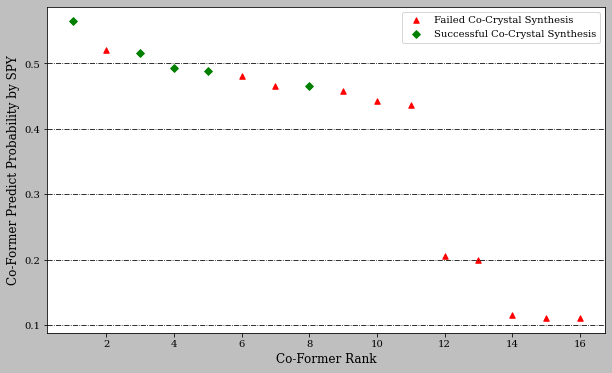

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('grayscale')
# plt.grid(b=None)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
group = input_y
cdict = {1: 'green', 0: 'red'}
mdict = {1: "D", 0: "^" }
scatter_x = np.arange(1, 17, 1)

fig, ax = plt.subplots()
for g in np.unique(group):
    if(g == 0):
      label_name = "Failed Co-Crystal Synthesis"
    else:
      label_name = "Successful Co-Crystal Synthesis"
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], y_proba_neg_unlablled_dul_df_SPY[ix], c = cdict[g], label = label_name, s = 30, marker=mdict[g])
ax.legend()
plt.rcParams["figure.figsize"] = (10,6)
plt.grid(linestyle='-.',axis="y")
plt.xlabel('Co-Former Rank', fontsize=12)
plt.ylabel('Co-Former Predict Probability by SPY', fontsize=12)
plt.savefig(fname='Co-Former_rank.png',dpi=400, bbox_inches = 'tight')
plt.show()

# Notice that 4,6,8,9,10 is all contains C60 

## 6.1 Model Preidct with new parameters

In [ ]:
y_predict = model_copy.predict(X)
y_proba = model_copy.predict_proba(X)

X_unlabelled = X[y==0]
X_unlabelled = X_unlabelled.reset_index(drop=True)


In [ ]:
top_zinc_index = X_unlabelled[y_proba[y==0] >= 0.5].index
top_zinc_index

Int64Index([ 1053,  1879,  2452,  3838,  4032,  4225,  4228,  4261,  4417,
             4420,
            ...
            44985, 44993, 45004, 45019, 45020, 45202, 45304, 45390, 45460,
            45581],
           dtype='int64', length=223)

In [ ]:
res_Spy = unlabelled_org.iloc[top_zinc_index,:]
# res_Spy.reset_index(drop=True, inplace=True)
confidence = pd.DataFrame(y_proba[y==0][top_zinc_index])
confidence.index = top_zinc_index
res_Spy = pd.concat([res_Spy,confidence],axis = 1)
res_Spy = res_Spy.rename(columns={0: 'confidence'})

In [ ]:
invaild_index = res_Spy.index[res_Spy.index<=22791]
invaild_index += 22791
invaild_index

Int64Index([23844, 24670, 25243, 26629, 26823, 27016, 27019, 27052, 27208,
            27211,
            ...
            45145, 45202, 45229, 45304, 45349, 45390, 45444, 45460, 45544,
            45581],
           dtype='int64', length=121)

In [ ]:
#Print the molecular combination with the highest predicted probability ### CHECKPOINT2
invaild_index = invaild_index.intersection(res_Spy.index)
res_Spy = res_Spy.drop(invaild_index,axis=0)


#remove some comb which CSD have
res_Spy=res_Spy[~res_Spy['comb'].isin(['comb20579', 'comb22010', 'comb22195','comb22384','comb22787','comb20579_', 'comb22010_', 'comb22195_','comb22384_','comb22787_'])]
res_Spy = res_Spy.sort_values('confidence',ascending=False)
res_Spy

,comb,mol1,mol2,confidence
19350,comb19351,ZINC000059029793,ZINC000000967534,0.991763
5917,comb5918,ZINC000100074226,ZINC000000967534,0.988850
19183,comb19184,ZINC000038147440,ZINC000000967534,0.987339
19012,comb19013,ZINC000008034701,ZINC000000967534,0.987339
19267,comb19268,ZINC000057677596,ZINC000000967534,0.987339
...,...,...,...,...
21810,comb21811,ZINC000169747359,ZINC000000968282,0.505776
22653,comb22654,ZINC000003898186,ZINC000085548520,0.505514
13744,comb13745,ZINC000001665359,ZINC000085548520,0.504367
4644,comb4645,ZINC000064624956,ZINC000085548520,0.501648


In [ ]:
# Print the order of the most frequently occurring molecules
mol_occur = res_Spy.iloc[:,1:3].apply(pd.value_counts)
mol_occur = mol_occur.fillna(0)
mol_occur['mol_occur_times'] = mol_occur['mol1'] + mol_occur['mol2']
mol_occur = mol_occur.sort_values('mol_occur_times',ascending=False)
mol_occur

,mol1,mol2,mol_occur_times
ZINC000085548520,2.0,51.0,53.0
ZINC000000967534,14.0,31.0,45.0
ZINC000000968282,7.0,18.0,25.0
ZINC000197382366,4.0,0.0,4.0
ZINC000002510896,3.0,0.0,3.0
...,...,...,...
ZINC000001758808,1.0,0.0,1.0
ZINC000001845807,1.0,0.0,1.0
ZINC000000165307,1.0,0.0,1.0
ZINC000002568170,0.0,1.0,1.0


In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, auc




#model predicts probabilities of positive class
p = model_copy.predict_proba(X_copy)

 
    
#FIGURE
plt.figure(figsize=[15,4])
    
    
#2 -- Distributions of Predicted Probabilities of both classes
df = pd.DataFrame({'probPos':p, 'target': y_copy})
plt.hist(df[df.target==1].probPos, log = True, bins=25,alpha=.5, color='green',  label='Pos')
plt.hist(df[df.target==0].probPos, log = True, bins=25,alpha=.5, color='red', label='Neg')
plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
plt.xlim([0,1])
plt.title('Distributions of Predictions', size=15)
plt.xlabel('Positive Probability (predicted)', size=13)
plt.ylabel('Samples (normalized scale)', size=13)
plt.legend(loc="upper right")
df